In [57]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [24]:
data1=pd.read_csv("D:\sih\load forecasting.csv")
df = pd.DataFrame(data = data1)

In [25]:
df.info

<bound method DataFrame.info of               Date_Time  Relative Humidity in %  Temperature  \
0      01-01-2017 00:00                    88.0       14.664   
1      01-01-2017 01:00                     NaN       14.052   
2      01-01-2017 02:00                     NaN       13.581   
3      01-01-2017 03:00                    78.0       13.197   
4      01-01-2017 04:00                     NaN       12.750   
...                 ...                     ...          ...   
26275  12/31/2019 19:00                     NaN        5.878   
26276  12/31/2019 20:00                     NaN        5.850   
26277  12/31/2019 21:00                    90.0        5.745   
26278  12/31/2019 22:00                     NaN        5.499   
26279  12/31/2019 23:00                     NaN        5.143   

       Radiation value in MJ/m^2  Wind Direction  Wind speed in kmph  \
0                            0.0             9.0                 4.0   
1                            0.0             NaN       

In [26]:
df.set_index('Date_Time',inplace=True)

In [27]:
df.head()

,Relative Humidity in %,Temperature,Radiation value in MJ/m^2,Wind Direction,Wind speed in kmph,Demand in MW,Kerala Holidays
Date_Time,,,,,,,
01-01-2017 00:00,88.0,14.664,0.0,9.0,4.0,2398.66,True
01-01-2017 01:00,NaN,14.052,0.0,NaN,NaN,2238.83,True
01-01-2017 02:00,NaN,13.581,0.0,NaN,NaN,2161.29,True
01-01-2017 03:00,78.0,13.197,0.0,14.0,4.0,2094.65,True
01-01-2017 04:00,NaN,12.750,0.0,NaN,NaN,2064.19,True


In [28]:
features = df.iloc[:,:-1].values

In [29]:
features

array([[  88.   ,   14.664,    0.   ,    9.   ,    4.   , 2398.66 ],
       [     nan,   14.052,    0.   ,      nan,      nan, 2238.83 ],
       [     nan,   13.581,    0.   ,      nan,      nan, 2161.29 ],
       ...,
       [  90.   ,    5.745,    0.   ,    0.   ,    0.   , 3555.91 ],
       [     nan,    5.499,    0.   ,    0.   ,    0.   , 3413.72 ],
       [     nan,    5.143,    0.   ,    0.   ,    0.   , 3254.1  ]])

In [39]:
df.isnull().sum()/len(df)

Relative Humidity in %       0.669863
Temperature                  0.000000
Radiation value in MJ/m^2    0.000000
Wind Direction               0.473364
Wind speed in kmph           0.473554
Demand in MW                 0.000000
Kerala Holidays              0.000000
dtype: float64

In [40]:
#so many missing values.hence droping out those columns.
df.drop(('Relative Humidity in %') ,axis=1, inplace=True)
df.drop(('Wind speed in kmph'), axis=1, inplace=True)
df.drop(('Wind Direction'), axis=1, inplace=True)

In [41]:
df.head()

,Temperature,Radiation value in MJ/m^2,Demand in MW,Kerala Holidays
Date_Time,,,,
01-01-2017 00:00,14.664,0.0,2398.66,True
01-01-2017 01:00,14.052,0.0,2238.83,True
01-01-2017 02:00,13.581,0.0,2161.29,True
01-01-2017 03:00,13.197,0.0,2094.65,True
01-01-2017 04:00,12.750,0.0,2064.19,True


In [42]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [43]:
target_names = ['Demand in MW']

In [44]:
df_targets = df[target_names].shift(-shift_steps)

In [45]:
x_data = df.values[0:-shift_steps]

In [46]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (26256, 4)


In [47]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)


<class 'numpy.ndarray'>
Shape: (26256, 1)


In [48]:
num_data = len(x_data)
num_data

26256

In [49]:
train_split = 0.9

In [50]:
num_train = int(train_split * num_data)
num_train

23630

In [51]:
num_test = num_data - num_train
num_test

2626

In [52]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

26256

In [53]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

26256

In [54]:
num_x_signals = x_data.shape[1]
num_x_signals

4

In [55]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [58]:
x_scaler = MinMaxScaler()

In [59]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [60]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [61]:
x_test_scaled = x_scaler.transform(x_test)

In [62]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [63]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(23630, 4)
(23630, 1)


In [64]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [65]:
batch_size = 150
sequence_length = 24 * 7 
sequence_length

168

In [66]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [67]:
x_batch, y_batch = next(generator)

In [68]:
print(x_batch.shape)
print(y_batch.shape)

(150, 168, 4)
(150, 168, 1)


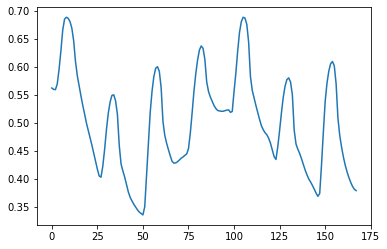

In [69]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

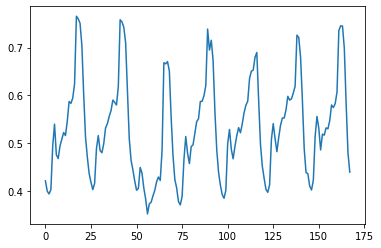

In [70]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [71]:

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [72]:
model = Sequential()

In [73]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [74]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [75]:

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [76]:
warmup_steps = 50

In [77]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [78]:
optimizer = RMSprop(lr=1e-3)

In [79]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics = ['accuracy'])

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         795648    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 796,161
Trainable params: 796,161
Non-trainable params: 0
_________________________________________________________________


In [81]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [82]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [83]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [84]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [85]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [86]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 8.4921e-05
Epoch 00001: val_loss improved from inf to 0.00488, saving model to 23_checkpoint.keras
100/100 [==============================] - 140s 1s/step - loss: 0.0099 - accuracy: 8.4921e-05 - val_loss: 0.0049 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 8.8095e-05
Epoch 00002: val_loss improved from 0.00488 to 0.00371, saving model to 23_checkpoint.keras
100/100 [==============================] - 143s 1s/step - loss: 0.0052 - accuracy: 8.8095e-05 - val_loss: 0.0037 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 9.4048e-05
Epoch 00003: val_loss improved from 0.00371 to 0.00354, saving model to 23_checkpoint.keras
100/100 [==============================] - 143s 1s/step - loss: 0.0044 - accuracy: 9.4048e-05 - val_loss: 0.0035 - val_acc

In [87]:

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [88]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.0000e+00


In [89]:
print("loss (test-set):", result)

loss (test-set): [0.0018594226567074656, 0.0]


In [90]:
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [91]:

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

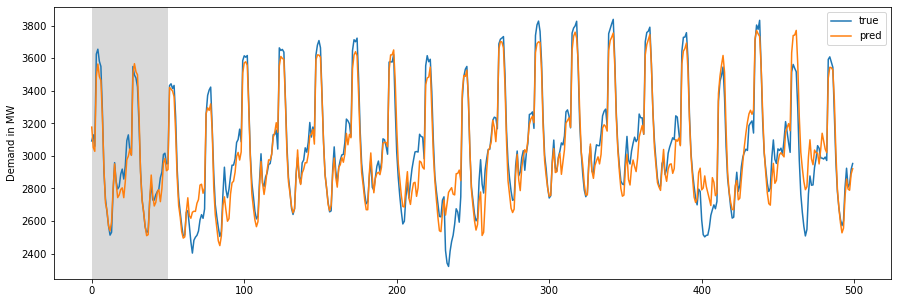

In [96]:
plot_comparison(start_idx=10000, length=500, train=True)
#predictions on training set

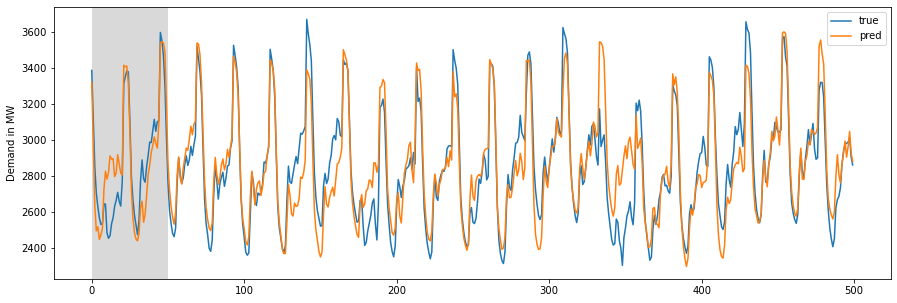

In [95]:
plot_comparison(start_idx=200, length=500, train=False)
#predictions on testing set

In [98]:
model.predict(df)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 01-01-2017 00:00 to 12/31/2019 23:00
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                26280 non-null  float64
 1   Radiation value in MJ/m^2  26280 non-null  float64
 2   Demand in MW               26280 non-null  float64
 3   Kerala Holidays            26280 non-null  bool   
dtypes: bool(1), float64(3)
memory usage: 846.9+ KB


In [100]:
df.shape

(26280, 4)